# Projeto 1 - Ciência dos Dados

Nome: Breno Quessie Barbosa de Lima

Nome: Davi Reis Vieira de Souza

**Atenção:** Serão permitidos grupos de três pessoas, mas com uma rubrica mais exigente. Grupos deste tamanho precisarão fazer um questionário de avaliação de trabalho em equipe

___
Carregando algumas bibliotecas:

In [121]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython.display import display
pd.options.display.max_rows = 20

**Em `filename`, coloque o nome do seu arquivo de dados!**

In [122]:
import os

filename = 'skybrasil.xlsx'
if filename in os.listdir():
    print(f'Encontrei o arquivo {filename}, tudo certo para prosseguir com o Projeto!')
else:
    print(f'Não encontrei o arquivo {filename} aqui no diretório {os.getcwd()}, será que você não baixou o arquivo?')

Encontrei o arquivo skybrasil.xlsx, tudo certo para prosseguir com o Projeto!


Carregando a base de dados com os tweets classificados como relevantes e não relevantes:

In [123]:
train = pd.read_excel(filename)
train.head(5)

,Classificação,Treinamento
0,2,@skybrasil poxa.. em plena pandemia subindo pr...
1,2,@skybrasil bora arrumar isso ai pelo amor de d...
2,2,@maurinhodutra @skybrasil @sbtonline @libertad...
3,1,@coalhadatricolo @canalesporte09 @skybrasil @s...
4,2,um forte abraço pra @skybrasil chuva. trovejo...


In [124]:
test = pd.read_excel(filename, sheet_name = 'Teste')
test.head(5)

,Classificação,Teste
0,0,@maurinhodutra @skybrasil @sbtonline @libertad...
1,1,@skyresponde @skybrasil @proconrj @reclameaqui...
2,0,rt @minhaoperadora: nova opção chega para subs...
3,2,rt @danielgonzaga: a @skyresponde @skybrasil p...
4,0,@christian_cruel @skybrasil larga essa sky gat...


In [125]:
train['Classificação'] = train['Classificação'].astype('category')
train['Classificação'].cat.categories = ('Irrelevante','Neutro','Relevante')
train.head(5)

,Classificação,Treinamento
0,Relevante,@skybrasil poxa.. em plena pandemia subindo pr...
1,Relevante,@skybrasil bora arrumar isso ai pelo amor de d...
2,Relevante,@maurinhodutra @skybrasil @sbtonline @libertad...
3,Neutro,@coalhadatricolo @canalesporte09 @skybrasil @s...
4,Relevante,um forte abraço pra @skybrasil chuva. trovejo...


In [126]:
test['Classificação'] = test['Classificação'].astype('category')
test['Classificação'].cat.categories = ('Irrelevante','Neutro','Relevante')
test.head(5)

,Classificação,Teste
0,Irrelevante,@maurinhodutra @skybrasil @sbtonline @libertad...
1,Neutro,@skyresponde @skybrasil @proconrj @reclameaqui...
2,Irrelevante,rt @minhaoperadora: nova opção chega para subs...
3,Relevante,rt @danielgonzaga: a @skyresponde @skybrasil p...
4,Irrelevante,@christian_cruel @skybrasil larga essa sky gat...


-----------Dataframe de Treinamento------------
Relevante: 263
Neutro: 123
Irrelevante: 114
-----------------------------------------------


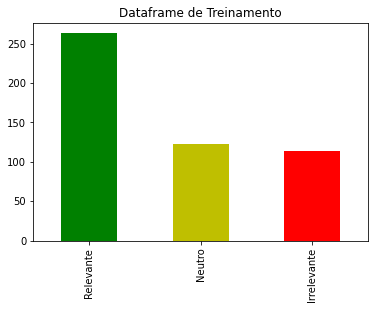

In [127]:
train_value_counts = train['Classificação'].value_counts()
print('-----------Dataframe de Treinamento------------')
print('Relevante:', train_value_counts[2])
print('Neutro:', train_value_counts[1])
print('Irrelevante:', train_value_counts[0])
print('-----------------------------------------------')

train_value_counts.plot(kind='bar', title='Dataframe de Treinamento',color = ['g', 'y','r']);

-----------Dataframe de Treinamento------------
Relevante: 263
Neutro: 123
Irrelevante: 114
-----------------------------------------------


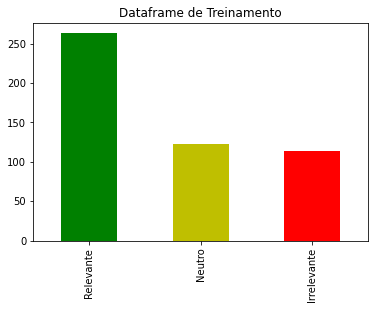

In [128]:
train_value_counts = train['Classificação'].value_counts()
print('-----------Dataframe de Treinamento------------')
print('Relevante:', train_value_counts[2])
print('Neutro:', train_value_counts[1])
print('Irrelevante:', train_value_counts[0])
print('-----------------------------------------------')

train_value_counts.plot(kind='bar', title='Dataframe de Treinamento',color = ['g', 'y','r']);

-----------Dataframe de Treinamento------------
Relevante: 263
Neutro: 123
Irrelevante: 114
-----------------------------------------------


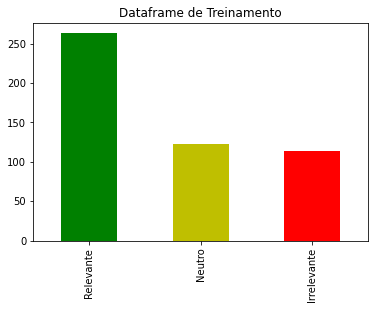

In [129]:
train_value_counts = train['Classificação'].value_counts()
print('-----------Dataframe de Treinamento------------')
print('Relevante:', train_value_counts[2])
print('Neutro:', train_value_counts[1])
print('Irrelevante:', train_value_counts[0])
print('-----------------------------------------------')

train_value_counts.plot(kind='bar', title='Dataframe de Treinamento',color = ['g', 'y','r']);

--------------Dataframe de Teste---------------
Relevante: 116
Neutro: 72
Irrelevante: 64
-----------------------------------------------


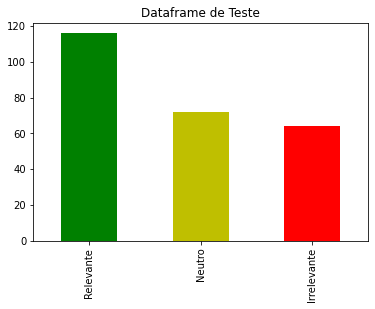

In [130]:
test_value_counts = test['Classificação'].value_counts()
print('--------------Dataframe de Teste---------------')
print('Relevante:', test_value_counts[2])
print('Neutro:', test_value_counts[1])
print('Irrelevante:', test_value_counts[0])
print('-----------------------------------------------')

test_value_counts.plot(kind='bar', title='Dataframe de Teste',color = ['g', 'y','r']);

# Classificador automático de sentimento


Faça aqui uma descrição do seu produto e o que considerou como relevante ou não relevante na classificação dos tweets.

Produto escolhido: Sky Brasil, uma empresa concessionária de serviços de telecomunicações brasileira. Trabalha com televisão por assinatura via satélite e internet banda larga 4G.

Consideramos relevante os tweets que possuem reclamações ou elogios pertinentes para a empresa, os quais podem agregar com feedbacks para melhorar a qualidade do serviço, atendimento ou na resolução de problemas técnicos. É classificado como neutro os tweets que possuem alguma citação direta com o produto, mas não agregam para o melhoramento. A classificação como irrelevante diz respeito aos tweets que são citações incompletas, as quais não fazem sentido, ou propagandas do próprio produto sobre os seus serviços, ou seja, conteúdo que não tem valor para melhorar a Sky.

## Montando um Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine  seu classificador.

$P(C|frase) = \frac{P(frase|C) P(C)}{P(frase)}$

$Frase$ = Esse é apenas um exemplo da equação

$P(frase|C) = P(Esse|C).P(é|C).P(apenas|C).P(um|C).P(exemplo|C).P(da|C).P(equação|C)$


Laplace Smoothing:
$P(W) = \frac{W_{count} + k}{total_{count} + k * |classificação|}$

$P(C|frase) = P(Esse) * P(é) * P(apenas) *...*P(C)$


$\log P(C)+ \log P(Esse|C)+ \log P(é|C)+...+\log P(equação|C)$

$P(C|Palavra) = \frac{P(Palavra|C) + 1}{PalavrasporClassificação + Palavras Total}$

$P(C|Frase) = P(C|Palavra1)* P(C|Palavra2)* P(C|Palavra3)* P(C|Palavra4)* P(C)$

[Why do we need Laplace smoothing in Naive Bayes while logarithm may resolve the problem?](https://stats.stackexchange.com/questions/274251/why-do-we-need-laplace-smoothing-in-naive-bayes-while-logarithm-may-resolve-the)

### Funções de limpeza e tratamento

In [218]:
import re 

def cleanup(frase_suja):
    frase_limpa = re.sub(r'http\S+', '', frase_suja, flags=re.MULTILINE) #Removendo Links no Tweet
    frase_limpa = " ".join(re.findall("(\w+|[^\w ]+)",frase_limpa)) #Adiciona espaços entre os emojis
    frase_limpa = re.sub('\s*([@])\s*', r' \1', frase_limpa) #Juntando @ anteriormente separados
    frase_limpa = re.sub(re.compile('[!-.:?;]'), '', frase_limpa) #Removendo pontuações e sinais
    frase_limpa=re.sub('(\s+)',' ',frase_limpa) #Removendo multiplos espaços
    frase_limpa=frase_limpa.lower() #Deixando todas as letras em minúsculo
    
    return frase_limpa 

### Montando o Classificador

In [219]:
from collections import defaultdict

In [266]:
class NaiveBayesModel:
        
    def dictIncrement(self,str_array,dict_index):
        str_array=str_array[0]
            
        for single_word in str_array.split():
            #Adiciona quantidade de vezes que a palavra aparece por classificação no dicionário
            self.classifications_dicts[dict_index][single_word]+= 1 
                  
    def fit(self,dataset,labels):
        self.training_strs=dataset #Strings com os tweets
        self.labels=labels #Strings com as classificações
        self.classifications=np.unique(labels) #Lista com classificações
        self.classifications_dicts=np.array([defaultdict(lambda: 0) for i in range(self.classifications.shape[0])]) #Lista de dicionários por classificação

        if not isinstance(self.training_strs,np.ndarray): # Redundância caso não cheguem arrays 
            self.training_strs=np.array(self.training_strs)
            
        if not isinstance(self.labels,np.ndarray): # Redundância caso não cheguem arrays 
            self.labels=np.array(self.labels)
            
        for classification_index,classification in enumerate(self.classifications): 
            unique_class_array=self.training_strs[self.labels==classification] # Pega cada frase por classificação           
            unique_class_array_cleaned=[cleanup(i) for i in unique_class_array] #Limpa cada frase
            unique_class_array_cleaned=pd.DataFrame(data=unique_class_array_cleaned) # Cria um DF organizado por classificação
            
            np.apply_along_axis(self.dictIncrement,1,unique_class_array_cleaned,classification_index) # Função dictIncrement         
        
        #P(W)=(Count(W|C)+1)/[Count(C)+V])*P(C)
        classification_prob=np.empty(self.classifications.shape[0]) # P(C)
        all_words=[]
        clas_word_counts=np.empty(self.classifications.shape[0]) # Total de Palavras por Classificação
        for classification_index,classification in enumerate(self.classifications):
            classification_prob[classification_index]=np.sum(self.labels==classification)/float(self.labels.shape[0]) # P(C)=(N° C)/Total de Classificações
            clas_word_counts[classification_index]=np.sum(np.array(list(self.classifications_dicts[classification_index].values()))) # nº Palavras/classificação
            # Palavras/Classificação                          
            all_words+=self.classifications_dicts[classification_index].keys()                                                      
        
        # Lista de todas as palavras sem repetição        
        self.vocaburary=np.unique(np.array(all_words))
        # Total de palavras sem repetição
        self.vocaburary_size=self.vocaburary.shape[0]
        
        #computing denominator value                                      
        denominator=np.array([clas_word_counts[classification_index]+self.vocaburary_size for classification_index,classification in enumerate(self.classifications)])

        #[Dict with words({word:word_count}),Classification probability, denominator value]
        self.category_array=[(self.classifications_dicts[classification_index],classification_prob[classification_index],denominator[classification_index]) for classification_index,classification in enumerate(self.classifications)]                               
        self.category_array=np.array(self.category_array)
        
    def predictStrForEachClassification(self,phrase):                                                                                                                
        words_prop=np.zeros(self.classifications.shape[0]) #to store probability for each class
        
        #finding probability for each class of the given test example
        for classification_index,classification in enumerate(self.classifications): 
            phrase=cleanup(phrase)
            for test_token in phrase.split(): #split the test example and get p of each test word                            
                
                #Numerator                         
                test_token_counts=self.category_array[classification_index][0].get(test_token,0)+1
                
                #Probability for this Word                            
                word_prob=test_token_counts/float(self.category_array[classification_index][2])  
                
                #We are using Log to prevent negative values and optimize process
                words_prop[classification_index]+=np.log(word_prob)
                                              
        #P(W)=(Count(W|C)+1)/[Count(C)+V])*P(C) 
        phrase_prop=np.empty(self.classifications.shape[0])
        for classification_index,classification in enumerate(self.classifications):
            phrase_prop[classification_index]=words_prop[classification_index]+np.log(self.category_array[classification_index][1])                                  
      
        return phrase_prop
   
    def predict(self,test_set): 
        predictions=[] 
        for test_str in test_set:                                               
            phrase_prop=self.predictStrForEachClassification(test_str) 
            predictions.append(self.classifications[np.argmax(phrase_prop)])
        return np.array(predictions)

# Verificando a performance do Classificador

Agora você deve testar o seu classificador com a base de Testes.

In [267]:
train_data=train['Treinamento']
train_labels=train['Classificação']

In [268]:
nb=NaiveBayesModel()

print ("Treinando o Modelo...")
 
nb.fit(train_data,train_labels)

print ('\nTreino Completo!')

Treinando o Modelo...

Treino Completo!


In [269]:
test_labels=test['Classificação']
test_data=test['Teste']

In [270]:
novas_classificacoes = nb.predict(test_data)

In [271]:
test['Previsão']=novas_classificacoes
test.head()

,Classificação,Teste,Previsão
0,Irrelevante,@maurinhodutra @skybrasil @sbtonline @libertad...,Neutro
1,Neutro,@skyresponde @skybrasil @proconrj @reclameaqui...,Relevante
2,Irrelevante,rt @minhaoperadora: nova opção chega para subs...,Irrelevante
3,Relevante,rt @danielgonzaga: a @skyresponde @skybrasil p...,Relevante
4,Irrelevante,@christian_cruel @skybrasil larga essa sky gat...,Neutro


In [272]:
#Salva o Dataframe com Previsão
if not os.path.isfile('skybrasil_previsto.xlsx'):
    writer = pd.ExcelWriter('skybrasil_previsto.xlsx')
    test.to_excel(excel_writer = writer, index = False)
    writer.save()

# Concluindo

In [273]:
acurancia=np.sum(test['Previsão']==test_labels)/test_labels.shape[0]

print ("Acurância do Modelo: ",acurancia*100,"%")

Acurância do Modelo:  58.333333333333336 %


In [274]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, target_names, title='Matriz de Confusão', cmap=None, normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Classificação Verdadeira')
    plt.xlabel('Previsão\nAcurácia={:0.4f}; Classificação Incorreta={:0.4f}'.format(accuracy, misclass))
    plt.show()

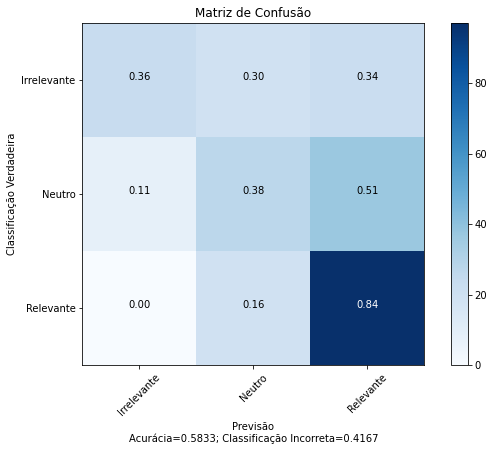

In [275]:
plot_confusion_matrix(confusion_matrix(test['Classificação'], test['Previsão']), ['Irrelevante', 'Neutro','Relevante'])

In [276]:
filtro_I = test_labels=='Irrelevante'
filtro_I_verdadeiro = (test_labels=='Irrelevante')&(test['Previsão']=='Irrelevante')
porcentagem_I_verdadeiro = (test.loc[filtro_I_verdadeiro].shape[0]/test.loc[filtro_I].shape[0])
porcentagem_I_falso=1-porcentagem_I_verdadeiro

print('Porcentagem de Irrelevantes Verdadeiros: ',porcentagem_I_verdadeiro*100, "%")
print('Porcentagem de Irrelevantes Falsos: ', porcentagem_I_falso*100, "%")

Porcentagem de Irrelevantes Verdadeiros:  35.9375 %
Porcentagem de Irrelevantes Falsos:  64.0625 %


In [277]:
filtro_N = test_labels=='Neutro'
filtro_N_verdadeiro = (test_labels=='Neutro')&(test['Previsão']=='Neutro')
porcentagem_N_verdadeiro = (test.loc[filtro_N_verdadeiro].shape[0]/test.loc[filtro_N].shape[0])
porcentagem_N_falso=1-porcentagem_N_verdadeiro

print('Porcentagem de Neutros Verdadeiros: ',porcentagem_N_verdadeiro*100, "%")
print('Porcentagem de Neutros Falsos: ', porcentagem_N_falso*100, "%")

Porcentagem de Neutros Verdadeiros:  37.5 %
Porcentagem de Neutros Falsos:  62.5 %


In [278]:
filtro_R = test_labels=='Relevante'
filtro_R_verdadeiro = (test_labels=='Relevante')&(test['Previsão']=='Relevante')
porcentagem_R_verdadeiro = (test.loc[filtro_R_verdadeiro].shape[0]/test.loc[filtro_R].shape[0])
porcentagem_R_falso=1-porcentagem_R_verdadeiro

print('Porcentagem de Relevantes Verdadeiros: ',porcentagem_R_verdadeiro*100, "%")
print('Porcentagem de Relevantes Falsos: ', porcentagem_R_falso*100, "%")

Porcentagem de Relevantes Verdadeiros:  83.62068965517241 %
Porcentagem de Relevantes Falsos:  16.37931034482759 %


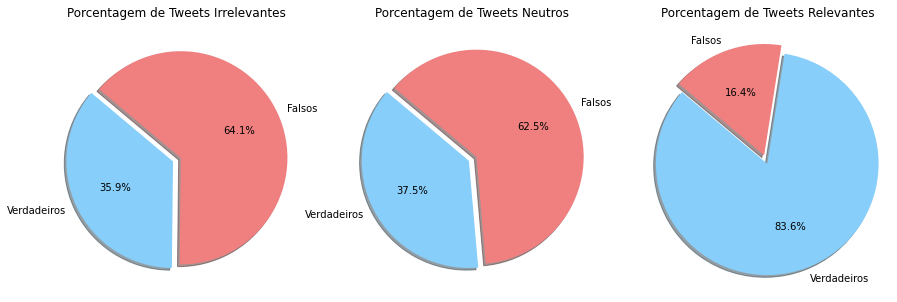

In [279]:
labels = 'Verdadeiros', 'Falsos'
I_plot = [porcentagem_I_verdadeiro, porcentagem_I_falso]
N_plot = [porcentagem_N_verdadeiro, porcentagem_N_falso]
R_plot = [porcentagem_R_verdadeiro, porcentagem_R_falso]
colors = ['lightskyblue', 'lightcoral']
explode = (0.08, 0) 

fig = plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.pie(I_plot, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title("Porcentagem de Tweets Irrelevantes")

plt.subplot(132)
plt.pie(N_plot, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title("Porcentagem de Tweets Neutros")

plt.subplot(133)
plt.pie(R_plot, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title("Porcentagem de Tweets Relevantes")
plt.show()

# Aperfeiçoamento:

Os trabalhos vão evoluir em conceito dependendo da quantidade de itens avançados:

- [X] Limpar: \n, :, ", ', (, ), etc SEM remover emojis
- [X] Corrigir separação de espaços entre palavras e emojis ou entre emojis e emojis
- [X] Propor outras limpezas e transformações que não afetem a qualidade da informação ou classificação
- [X] Criar categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante (3 categorias: C, mais categorias conta para B)
- [ ] Explicar por que não posso usar o próprio classificador para gerar mais amostras de treinamento
- [ ] Propor diferentes cenários para Naïve Bayes fora do contexto do projeto
- [ ] Sugerir e explicar melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)
- [X] Montar um dashboard que realiza análise de sentimento e visualiza estes dados

# Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**

[Applying Multinomial Naive Bayes to NLP Problems: A Practical Explanation](https://medium.com/syncedreview/applying-multinomial-naive-bayes-to-nlp-problems-a-practical-explanation-4f5271768ebf#:~:text=A%20solution%20would%20be%20Laplace,incorporated%20in%20every%20probability%20estimate.&text=this%20is%20a%20way%20of,it%20is%20called%20Laplace%20smoothing.) **Mais simples e Completo**

[Why do we need Laplace smoothing in Naive Bayes while logarithm may resolve the problem?](https://stats.stackexchange.com/questions/274251/why-do-we-need-laplace-smoothing-in-naive-bayes-while-logarithm-may-resolve-the)